In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
rootdir = 'LBQS1435-0134/STIS/'

In [3]:
file_list = glob.glob(rootdir + '*x1d.fits')

In [4]:
fits_list = [fits.open(f) for f in file_list]

In [5]:
spec_data_1 = fits.open(rootdir + 'oco705030_x1d.fits')
spec_data_2 = fits.open(rootdir + 'oco705020_x1d.fits')
spec_data_3 = fits.open(rootdir + 'oco705010_x1d.fits')
spec_data_4 = fits.open(rootdir + 'oco703050_x1d.fits')
spec_data_5 = fits.open(rootdir + 'oco703040_x1d.fits')
spec_data_6 = fits.open(rootdir + 'oco703030_x1d.fits')
spec_data_7 = fits.open(rootdir + 'oco703020_x1d.fits')
spec_data_8 = fits.open(rootdir + 'oco703010_x1d.fits')

In [6]:
exp_times = [f[1].header['EXPTIME'] for f in fits_list]
exp_wts = np.array(exp_times/np.sum(exp_times))

In [7]:
n_exps = len(fits_list)
n_orders = fits_list[0][1].data.shape[0]
n_pixels = fits_list[0][1].data[0][2].shape[0]

In [8]:
spec_orders = np.zeros((n_orders, n_pixels, 3))

In [9]:
for i in range(n_orders):
    spec_orders[i,:,0] = fits_list[0][1].data[n_orders-i-1][2]
    
    spec_orders[i,:,1] = np.sum([exp_wts[j]*fits_list[j][1].data[n_orders-i-1][6] for j in range(n_exps)], 
                                axis=0)
    
    #spec_orders[i,:,1] = spec_data_1[1].data[n_orders-i-1][6] + spec_data_2[1].data[n_orders-i-1][6] + spec_data_3[1].data[n_orders-i-1][6] + spec_data_4[1].data[n_orders-i-1][6] + spec_data_5[1].data[n_orders-i-1][6] + spec_data_6[1].data[n_orders-i-1][6] + spec_data_7[1].data[n_orders-i-1][6] + spec_data_8[1].data[n_orders-i-1][6]
        
    spec_orders[i,:,2] = np.sqrt(np.sum([exp_wts[j]**2*fits_list[j][1].data[n_orders-i-1][7]**2 
                                         for j in range(n_exps)], axis=0))
    
    #spec_orders[i,:,2] = np.sqrt(spec_data_1[1].data[n_orders-i-1][7]**2 + spec_data_2[1].data[n_orders-i-1][7]**2 + spec_data_3[1].data[n_orders-i-1][7]**2 + spec_data_4[1].data[n_orders-i-1][7]**2 + spec_data_5[1].data[n_orders-i-1][7]**2 + spec_data_6[1].data[n_orders-i-1][7]**2 + spec_data_7[1].data[n_orders-i-1][7]**2 + spec_data_8[1].data[n_orders-i-1][7]**2)

In [10]:
stitch_indices = np.zeros(n_orders-1, dtype=int)

In [11]:
for i in range(n_orders-1):

    wav_order_1 = spec_orders[i,:,0]
    wav_order_2 = spec_orders[i+1,:,0]

    del_wav_arr = wav_order_1-wav_order_2[0]

    idx = list(del_wav_arr).index(max(del_wav_arr[del_wav_arr<0]))

    stitch_indices[i] = idx

    n_rem_order_1 = len(wav_order_1[idx:])

    wav_order_2[0:n_rem_order_1] = wav_order_1[idx:].copy()

    spec_orders[i+1,:,0] = wav_order_2.copy()

In [12]:
wav_dict = {}

In [13]:
for i in range(n_orders-1):
    for j in range(stitch_indices[i]):
        wav_dict[spec_orders[i][j][0]] = []
        

for w in spec_orders[-1,:,0]:
    wav_dict[w] = []

In [14]:
wav_stitch = np.array(list(wav_dict.keys()))
flux_stitch = np.zeros(len(wav_stitch))
err_stitch = np.zeros(len(wav_stitch))

In [15]:
wav_stitch

array([1984.52450009, 1984.55721137, 1984.5899225 , ..., 2781.80521213,
       2781.84988548, 2781.89455859])

In [16]:
for i in range(n_orders):
    for j in range(n_pixels):
        wav_dict[spec_orders[i][j][0]].append([spec_orders[i][j][1],spec_orders[i][j][2]])

In [17]:
trim = False

In [18]:
for i in range(len(wav_dict)):
    
    wav = wav_stitch[i]
    
    flux_arr = wav_dict[wav]
    
    if(len(flux_arr) == 2):
        
        
        flux_stitch[i] = 0
        err_stitch[i] = 0
        
        if(trim == True):
        
            if(flux_arr[0][1] < flux_arr[1][1]):
            
                flux_stitch[i] = flux_arr[0][0]
                err_stitch[i] = flux_arr[0][1]
            
            else:
            
                flux_stitch[i] = flux_arr[1][0]
                err_stitch[i] = flux_arr[1][1]
                
        else:
            
            F1 = flux_arr[0][0]
            F2 = flux_arr[1][0]
            
            s1 = flux_arr[0][1]
            s2 = flux_arr[1][1]
            
            #w1 = s2**2*F1/(s1**2*F2 + s2**2*F1)
            w1 = s2**2/(s1**2 + s2**2)
            w2 = 1-w1

            flux_stitch[i] = w1*F1 + w2*F2
            err_stitch[i] = np.sqrt(w1**2*s1**2 + w2**2*s2**2)

    else:
        flux_stitch[i] = flux_arr[0][0]
        err_stitch[i] = flux_arr[0][1]  

Text(0, 0.5, 'Flux (ergs/s/cm^2)')

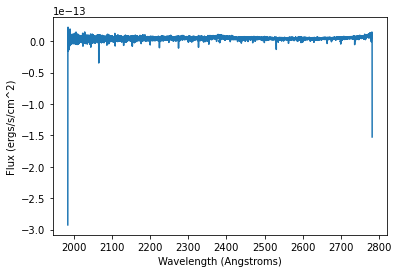

In [19]:
plt.plot(wav_stitch, flux_stitch)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (ergs/s/cm^2)')

Text(0, 0.5, 'Flux Error (ergs/s/cm^2)')

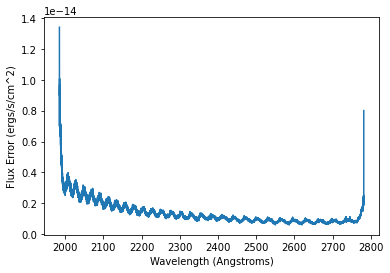

In [20]:
plt.plot(wav_stitch, err_stitch)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux Error (ergs/s/cm^2)')

Compare with Zhijie's stitch

In [21]:
spec_data_old = fits.open(rootdir + 'LBQS1435-0134_E230M.fits')

In [22]:
spec_data_old.info()

Filename: LBQS1435-0134/STIS/LBQS1435-0134_E230M.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     37   20850R x 10C   [E, E, E, J, E, E, E, E, E, D]   


In [23]:
spec_data_old[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.12a          
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   44 /Number of bytes per row                         
NAXIS2  =                20850 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   10 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [24]:
spec_stitch_old = pd.DataFrame(spec_data_old[1].data).to_numpy()

In [25]:
wav_stitch_old = spec_stitch_old[:,0]
flux_stitch_old = spec_stitch_old[:,1]
err_stitch_old = spec_stitch_old[:,2]

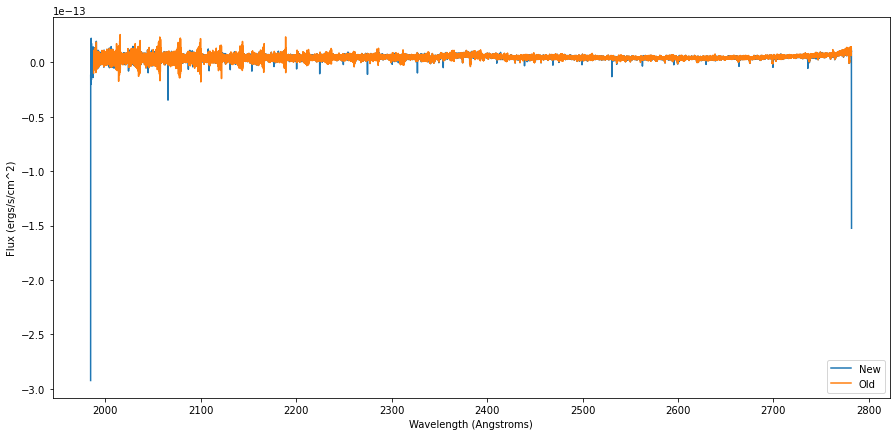

In [26]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch, flux_stitch, label='New')
ax.plot(wav_stitch_old, flux_stitch_old, label='Old')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (ergs/s/cm^2)')
ax.legend()

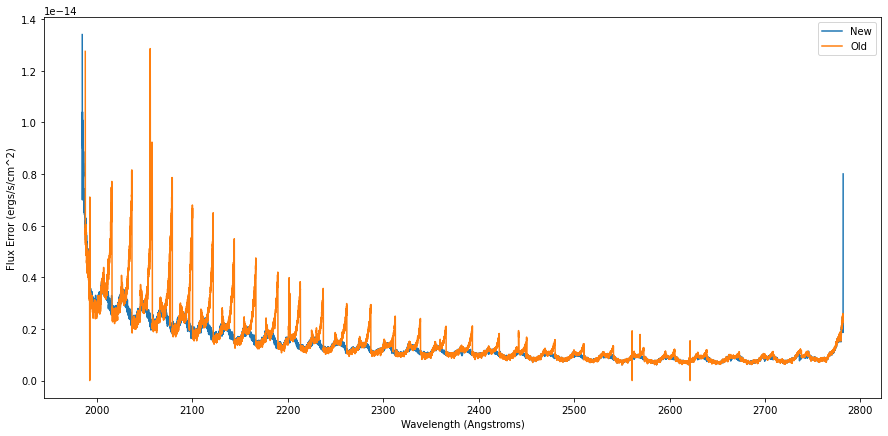

In [27]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_stitch, err_stitch, label='New')
ax.plot(wav_stitch_old, err_stitch_old, label='Old')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux Error (ergs/s/cm^2)')
ax.legend()